In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from nhits import NHiTS
import yaml

# Import needed libraries
from torch.utils.data import DataLoader

from dataset.dataset import UnivariateTSDataset

In [3]:
x = torch.randn((128,1,30))
F.interpolate(x, size=120, mode='nearest').squeeze()

tensor([[ 0.2569,  0.2569,  0.2569,  ..., -1.0972, -1.0972, -1.0972],
        [ 0.8754,  0.8754,  0.8754,  ..., -1.5343, -1.5343, -1.5343],
        [ 0.0558,  0.0558,  0.0558,  ..., -1.8765, -1.8765, -1.8765],
        ...,
        [-2.4085, -2.4085, -2.4085,  ..., -0.7587, -0.7587, -0.7587],
        [-0.7075, -0.7075, -0.7075,  ..., -0.6427, -0.6427, -0.6427],
        [ 0.9549,  0.9549,  0.9549,  ...,  0.1177,  0.1177,  0.1177]])

In [4]:
dataset = UnivariateTSDataset(
    path='../data/ETTm2.csv', 
    col='MULL', # replace 'desired_column' with the column name you want
    lookback_horizon=96, 
    forecast_horizon=24
)

# Initialize a DataLoader with your dataset
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device("mps")

with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)
losses = []

def train_model(lookback_horizon, forecast_size, batch_size, num_nhits_blocks, mlp_layer_num, hidden_size, pooling_kernel_size, downsampling_ratios, dropout_prob):
    model = NHiTS(
        lookback_horizon=lookback_horizon,
        forecast_size=forecast_size,
        num_nhits_blocks=num_nhits_blocks,
        mlp_layer_num=mlp_layer_num,
        hidden_size=hidden_size,
        pooling_kernel_size=pooling_kernel_size,
        downsampling_ratios=downsampling_ratios,
        dropout_prob=dropout_prob
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Create a list to store loss values of the last 10 epochs

    for epoch in range(config['epochs']):
        epoch_loss = 0.0
        batch_count = 0
        for batch in dataloader:  # assuming dataloader is previously defined
            # Zero the gradients
            optimizer.zero_grad()

            # Prepare the inputs and targets
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)
            epoch_loss += loss.item()
            batch_count += 1
            losses.append(loss)
            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()
            print(f'Epoch {epoch}: {loss}')



train_model(lookback_horizon= 96,
forecast_size= 24,
batch_size= 128,
num_nhits_blocks= 3,
mlp_layer_num= 2,
hidden_size= 512,
pooling_kernel_size= [2, 2, 1],
dropout_prob= 0.0,
downsampling_ratios= [4, 2, 1])

/Users/nicholashoffs/code/nhits/venv/lib/python3.11/site-packages/torch/nn/functional.py:3954: UserWarning: The operator 'aten::upsample_linear1d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return torch._C._nn.upsample_linear1d(input, output_size, align_corners, scale_factors)


Epoch 0: 89.31254577636719
Epoch 0: 20.955902099609375
Epoch 0: 13.797274589538574
Epoch 0: 12.574091911315918
Epoch 0: 12.430716514587402
Epoch 0: 9.117605209350586
Epoch 0: 8.271800994873047
Epoch 0: 5.746265411376953
Epoch 0: 5.337698936462402
Epoch 0: 3.9979896545410156
Epoch 0: 4.728146076202393
Epoch 0: 3.7525758743286133
Epoch 0: 4.205483913421631
Epoch 0: 4.181402206420898
Epoch 0: 3.1608664989471436
Epoch 0: 2.9673118591308594
Epoch 0: 5.467883110046387
Epoch 0: 3.0655744075775146
Epoch 0: 3.2241456508636475
Epoch 0: 2.822096586227417
Epoch 0: 3.7045955657958984
Epoch 0: 3.6705825328826904
Epoch 0: 3.453881025314331
Epoch 0: 2.3318605422973633
Epoch 0: 2.723663091659546
Epoch 0: 2.9758071899414062
Epoch 0: 3.0655832290649414
Epoch 0: 5.182059288024902
Epoch 0: 2.4338178634643555
Epoch 0: 2.755636215209961
Epoch 0: 2.2464184761047363
Epoch 0: 2.97724986076355
Epoch 0: 4.221317291259766
Epoch 0: 3.1607441902160645
Epoch 0: 2.621744394302368
Epoch 0: 3.5633323192596436
Epoch 0: 2

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

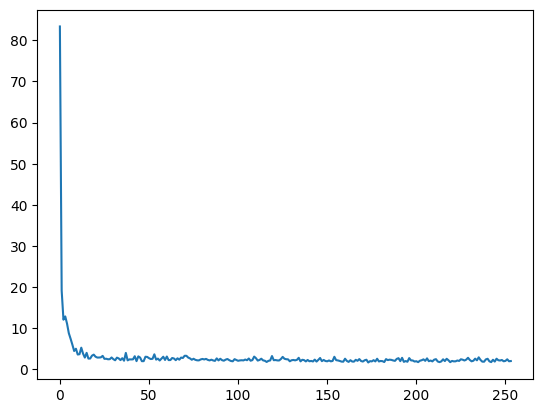

In [ ]:
plt.plot(torch.tensor(losses))

In [ ]:
print(torch.mean(torch.tensor(losses[-256:])))

tensor(2.9858)


In [ ]:
from nhits import NHiTSMulti

In [5]:
#...
from dataset.dataset import MultivariateTSDataset
# Initialize your dataset
dataset = MultivariateTSDataset(
    path='../data/ETTm2.csv', 
    cols=['MULL', 'OT', 'LULL'],  # list of desired columns
    lookback_horizon=120, 
    forecast_horizon=24
)

# Initialize a DataLoader with your dataset
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

def train_model(lookback_horizon, forecast_size, batch_size, num_nhits_blocks, mlp_layer_num, hidden_size, pooling_kernel_size, downsampling_ratios, dropout_prob):
    model = NHiTSMulti(
        lookback_horizon=lookback_horizon,
        forecast_size=forecast_size,
        num_nhits_blocks=num_nhits_blocks,
        mlp_layer_num=mlp_layer_num,
        hidden_size=hidden_size,
        pooling_kernel_size=pooling_kernel_size,
        downsampling_ratios=downsampling_ratios,
        dropout_prob=dropout_prob
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Create a list to store loss values of the last 10 epochs
    last_ten_losses = []

    for epoch in range(config['epochs']):
        epoch_loss = 0.0
        batch_count = 0
        for batch in dataloader:  # assuming dataloader is previously defined
            # Zero the gradients
            optimizer.zero_grad()

            # Prepare the inputs and targets
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)
            losses.append(loss)
            epoch_loss += loss.item()
            batch_count += 1

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()
            print(f'Epoch {epoch}: {loss}')


self.data.shape=(69680, 3)


In [11]:
train_model(120,24,256,3,3,512,[2,2,2],[4,2,1],0.0)

TypeError: object of type 'bool' has no len()